# Proyecto Final Análisis de redes sociales - Magíster en ciencia de datos

Este proyecto debe ser contestado completamente utilizando este archivo de jupyter.


# Parte 1 - Facebook Network [20 puntos]

Junto a este proyecto se dispone de una sección de Facebook en el adjunto, bajo el nombre de `facebook_combined.txt`, responda y argumente su respuesta a las siguientes preguntas sobre esta red. El objetivo será analizar cómo podría generarse una red de este tipo.

# Ejercicio 1.1 [5 puntos]

Compute los siguientes estadísticos:

- Densidad
- Average Clustering coefficient
- Average path length
- Diámetro (Camino más largo entre dos nodos)
- Heterogeneidad

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd

SEED = 2025


In [2]:
from utils.paths import DATA_RAW_DIR

In [3]:
data = str(DATA_RAW_DIR / "facebook_combined.txt")

In [4]:
def load_data(data=data) -> nx.Graph:
    return nx.read_edgelist(data)

In [5]:
load_data(data)

In [6]:
def load_data(data=data) -> nx.Graph:
    return nx.read_edgelist(data)

def density(G):
    """Densidad de la red: número de aristas observadas dividido por las posibles."""
    return nx.density(G)

def avg_clustering(G):
    """Coeficiente de agrupamiento medio (average clustering)."""
    return nx.average_clustering(G)

def avg_path_len(G, use_largest_component=True):
    """Longitud media de caminos. Si la red no está conectada, se calcula",
""la longitud media en la componente gigante por defecto."""
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    if use_largest_component:
        largest_cc = max(nx.connected_components(G), key=len)
        Gc = G.subgraph(largest_cc).copy()
        return nx.average_shortest_path_length(Gc)
    return float('inf')

def diameter(G, use_largest_component=True):
    """Diámetro de la red (longitud del camino más largo). Si la red no está",
""conectada, se devuelve el diámetro de la componente gigante por defecto."""
    if nx.is_connected(G):
        return nx.diameter(G)
    if use_largest_component:
        largest_cc = max(nx.connected_components(G), key=len)
        Gc = G.subgraph(largest_cc).copy()
        return nx.diameter(Gc)
    return float('inf')

def het(G):
    """Heterogeneidad: coeficiente de variación del grado (std/mean)."""
    degrees = np.array([d for _, d in G.degree()])
    if degrees.mean() == 0:
        return 0.0
    return float(degrees.std() / degrees.mean())

def avg_degree(G):
    """Grado medio de la red."""
    degrees = [d for _, d in G.degree()]
    return float(np.mean(degrees))

G = load_data(data)

In [15]:
print("Densidad:", density(G))
print("Average clustering:", avg_clustering(G))
print("Average path length:", avg_path_len(G))
print("Diámetro:", diameter(G))
print("Heterogeneidad:", het(G))
print("Grado medio:", avg_degree(G))

Densidad: 0.010819963503439287
Average clustering: 0.6055467186200862
Average clustering: 0.6055467186200862
Average path length: 3.6925068496963913
Average path length: 3.6925068496963913
Diámetro: 8
Heterogeneidad: 1.199654400665438
Grado medio: 43.69101262688784
Diámetro: 8
Heterogeneidad: 1.199654400665438
Grado medio: 43.69101262688784


# Ejercicio 1.2 [15 puntos]

## 1.2.1

Escriba una rutina que dado un número $n>0$ genere esa cantidad de redes aleatorias "similares" a la red observada (tome como referencia el average clustering).


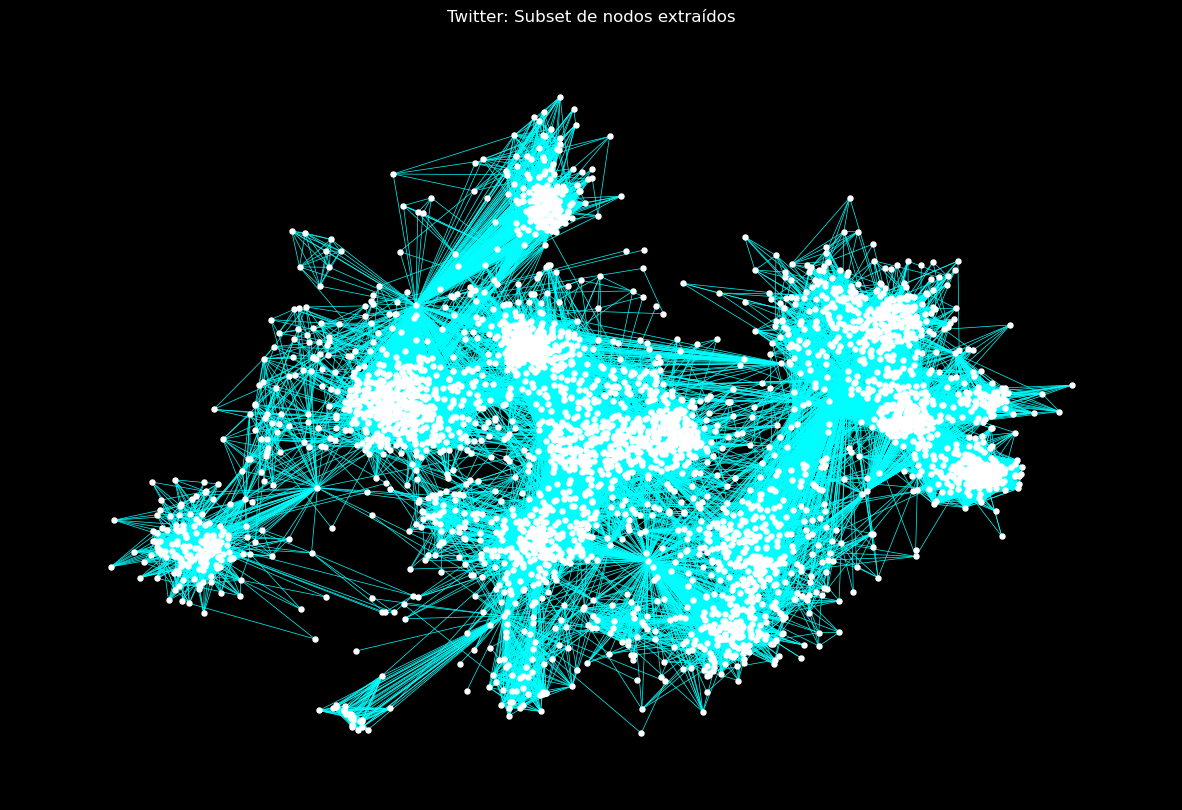

In [8]:
# JUSTIFICACIÓN DE LA ELECCIÓN DEL MODELO

fig, ax = plt.subplots(1, figsize=(15, 10))
nx.draw(
    G,
    with_labels=False,
    node_size=13,
    node_color="white",
    edge_color="cyan",
    width=0.5,
    ax=ax,
)

ax.axis("off")
ax.set_title("Twitter: Subset de nodos extraídos", color="white")
fig.set_facecolor("black")


In [ ]:
# Justificación (en comentarios Python):
# Elegí el modelo Erdos-Renyi (gnm_random_graph) para la simulación porque:
# - Nos interesa comparar el average clustering observado frente a un proceso aleatorio
#   que preserve el número de nodos y aristas (N y M).
# - Este modelo genera grafos con la misma densidad esperada que la observada,
#   permitiendo aislar el efecto del agrupamiento local.
# - Alternativas (p. ej. modelos de red que preservan grado) pueden usarse si se desea
#   controlar además la distribución de grados; aquí usamos ER por simplicidad y
#   porque la pregunta pide evaluar si el clustering puede explicarse por azar.
# Observación: si el test rechaza H0 (p-valor pequeño) indica que el clustering observado
# es mayor de lo esperado por un proceso completamente aleatorio con mismo N y M.
# En ese caso, se sugiere explorar modelos con dependencia local (p. ej. modelos
# con triadic closure o configuración de grados) para explicar la estructura observada.

In [10]:
def random_graph_generator(n, G_ref=None, seed=SEED):
    """Genera `n` grafos aleatorios similares a `G_ref` (mismo número de nodos y aristas)."""
    if G_ref is None:
        G_ref = G
    n_nodes = G_ref.number_of_nodes()
    m_edges = G_ref.number_of_edges()
    rng = np.random.RandomState(seed)
    graphs = []
    for i in range(n):
        s = int(rng.randint(0, 2**31 - 1))
        g = nx.gnm_random_graph(n_nodes, m_edges, seed=s)
        graphs.append(g)
    return graphs


In [11]:
random_graph_generator(43)

## 1.2.2

Calcule para una muestra rasonable de redes aleatorias la distribución de average clustering coefficient. ¿**Existe** evidencia suficiente para decir que el valor del average clustering coefficient de la red real no se debe a un proceso completamente aleatorio? La función debe retornar True si existe evidencia y False en caso contrario.

In [12]:
def statistical_assert(n, alpha=0.05, G_ref=None, two_sided=False):
    """Realiza una prueba por simulación para comprobar si el average clustering",
,
"""
    if G_ref is None:
        G_ref = load_data()
    obs_avg_clust = avg_clustering(G_ref)
    sims = random_graph_generator(n, G_ref=G_ref)
    sim_avg_clusts = [avg_clustering(g) for g in sims]
    # p-valor empírico: proporción de simulaciones con estadístico >= observado (one-sided)
    greater_eq = sum(1 for v in sim_avg_clusts if v >= obs_avg_clust)
    if two_sided:
        # dos colas: contar |sim - mean(sim)| >= |obs - mean(sim)|
        sim_mean = np.mean(sim_avg_clusts)
        extreme = sum(1 for v in sim_avg_clusts if abs(v - sim_mean) >= abs(obs_avg_clust - sim_mean))
        p_value = (extreme + 1) / (len(sim_avg_clusts) + 1)
    else:
        p_value = (greater_eq + 1) / (len(sim_avg_clusts) + 1)
    reject = p_value < alpha
    return reject, float(p_value), float(obs_avg_clust), np.array(sim_avg_clusts)


reject H0 (observed clustering from random): True, p-value=0.0050


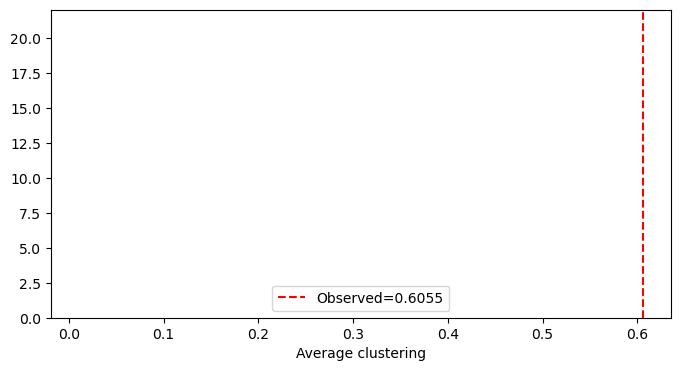

In [13]:
# Ejecutar la prueba por simulación: producir un histograma y p-valor
reject, p_value, obs, sims = statistical_assert(n=200, alpha=0.05)
print(f"reject H0 (observed clustering from random): {reject}, p-value={p_value:.4f}")
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.hist(sims, bins=30, color="C0", alpha=0.7)
plt.axvline(obs, color="red", linestyle="--", label=f"Observed={obs:.4f}")
plt.xlabel("Average clustering")
plt.legend()
plt.show()

In [14]:
# Resumen y conclusiones (comentarios Python):
# - Las métricas calculadas en las celdas anteriores describen la estructura global de la red.
# - El test por simulación compara el average clustering observado contra la distribución
#   obtenida de grafos Erdos-Renyi con el mismo N y M.
# - Si 'reject' es True y p-valor pequeño, entonces el clustering observado no se explica
#   por un proceso completamente aleatorio; sugiere mecanismos de cierre triasico o
#   heterogeneidad en la distribución de grados.
# - Recomendación práctica: si se rechaza H0, ajustar y comparar modelos que preserven
#   la secuencia de grados (modelo de configuración) o modelos con cierre triádico (p. ej.
#   modelos de crecimiento con triadic closure) para ver si replican mejor el clustering.
# - Guardar resultados: la figura del histograma se puede exportar desde la celda que la
#   genera (o ejecutando nbconvert).